In [1]:
import os 
import re 
import ast
import random 
from abc import ABC, abstractmethod
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 

MAIN_PATH = os.path.join("/Users", "jcheigh", "Thesis")
DATA_PATH = os.path.join(MAIN_PATH, "data")
PLOT_PATH = os.path.join(MAIN_PATH, "plots")
RES_PATH  = os.path.join(MAIN_PATH, "results")

PLOT_PATHS = {
    "error plots"     : f"{PLOT_PATH}/error plots/",
    "char plots"      : f"{PLOT_PATH}/char sum plots/",   
    "fourier plots"   : f"{PLOT_PATH}/fourier plots/",   
    }

PLOT_NAME  = {
    "error plots"     : r"p = (?P<prime>\d+) error plot.jpg",
    "char plots"      : r"p = (?P<prime>\d+) char sum plot.jpg",
    "fourier plots"   : r"p = (?P<prime>\d+) fourier exp plot.jpg"
    }

PLOT_PARAMS = {
    "error plots"     : ("prime"),
    "char plots"      : ("prime"),
    "fourier plots"   : ("prime"),
    }

CSV_PATHS = {
    "raw error"       : f"{DATA_PATH}/raw_error.csv",
    "processed_error" : f"{DATA_PATH}/processed_error.csv",
    "error stats"     : f"{DATA_PATH}/error stats.csv",
    "fourier stats"   : f"{DATA_PATH}/polya fourier stats.csv",
    "char sum stats"  : f"{DATA_PATH}/char sum stats.csv",
    'variance'        : f"{DATA_PATH}/variance.csv"
    }

EXP_PATHS = {
    "character sum"   : f"{DATA_PATH}/char sum lists/",
    "polya fourier"   : f"{DATA_PATH}/polya fourier lists/",
    "symmetry"        : f"{DATA_PATH}/symmetry/",
    "leg fixed n"     : f"{DATA_PATH}/legendre fixed n/",
    "error lists"     : f"{DATA_PATH}/error lists/",
    'antisymmetry'    : f"{DATA_PATH}/antisymmetry/",
    'translation'     : f"{DATA_PATH}/translation",
    'varying_H'       : f'{DATA_PATH}/varying_H',
    'r lists'         : f'{DATA_PATH}/r lists',
    'r sum lists'     : f'{DATA_PATH}/r sum lists',
    'r char sum lists': f'{DATA_PATH}/r char sum lists',
    'r diff sum lists': f'{DATA_PATH}/r diff sum lists',
    'j lists'         : f'{DATA_PATH}/j lists',
    'j1 lists'        : f'{DATA_PATH}/j1 lists'
    }  

EXP_NAME = {
    "symmetry"        : r"symmetry\(p=(?P<prime>\d+),d=(?P<delta>\d+)\)",
    "polya fourier"   : r"p = (?P<prime>\d+) fourier exp list",
    "character sum"   : r"p = (?P<prime>\d+) character sum list",
    "leg fixed n"     : r"n = (?P<n>\d+) legendre symbol list",
    "error lists"     : r"p = (?P<prime>\d+) error list",
    'antisymmetry'    : r"antisymmetry\(p=(?P<prime>\d+),d=(?P<delta>\d+)\)",
    'translation'     : 'translation means',
    'varying_H'       : r"p = (?P<prime>\d+) four exp (?P<low>/d+)-(?P<high>/d+)",
    'r lists'         : r"k = (?P<k>\d+), H = (?P<H>\d+) R(x)",
    'r sum lists'     : r"k = (?P<k>\d+), H in 1-(?P<H>\d+) R sum",
    'r char sum lists': r"k = (?P<k>\d+), H in 1-(?P<H>\d+) R char sum",
    'r diff sum lists': r"k = (?P<k>\d+), H = (?P<H>\d+) R diff sum",
    'j lists'         : r'k = (?P<k>\d+), H = (?P<H>\d+) J list',
    'j1 lists'        : r'k = (?P<k>\d+), H = (?P<H>\d+) J1 list'
    } 

EXP_PARAMS = {
    "symmetry"        : ('prime', 'delta'),
    "polya fourier"   : ("prime"),
    "character sum"   : ("prime"),
    "leg fixed n"     : ('n'),
    "error lists"     : ("prime"),
    "antisymmetry"    : ('prime', 'delta'),
    'translation'     : (),
    'varying_H'       : ('prime', 'low', 'high'),
    'r lists'         : ('k', 'H'),
    'r sum lists'     : ('k', 'H'),
    'r char sum lists': ('k', 'H'),
    'r diff sum lists': ('k', "H"),
    'j lists'         : ('k', 'H'),
    'j1 lists'         : ('k', 'H')
    }   

def process(lst):
    processed_lst = []  

    for item in lst:
        # If the item starts with a '(', consider it a tuple
        if item.startswith('('):
            try:
                # Safely evaluate the item as a tuple
                processed_tuple = ast.literal_eval(item)
                processed_lst.append(processed_tuple)
            except ValueError:
                # If there's an error, just append the original string
                processed_lst.append(item)
        else:
            try:
                # Convert the item to a float
                processed_lst.append(float(item))
            except ValueError:
                # If there's an error, just append the original string
                processed_lst.append(item)

    return processed_lst

def fetch_data(experiment):
    ### Usage: fetch_data('polya fourier')
    path   = EXP_PATHS[experiment]  # f"{DATA_PATH}/symmetry/",
    name   = EXP_NAME[experiment]   # symmetry\(p=(?P<prime>\d+),d=(?P<delta>\d+)\)",
    params = EXP_PARAMS[experiment] # (prime, delta)
    
    data = {}
    for filename in os.listdir(path):
        # Match the filename with the regex pattern
        match = re.search(name, filename)
        if match:
            if isinstance(params, str):
                key = int(match.group(params))
            elif isinstance(params, tuple):
                key = tuple([int(match.group(param)) for param in params]) # (17, 3)
            else:
                raise Exception(f"Invalid Params Type: {params}")

            # Read the file and get the list of elements
            with open(os.path.join(path, filename), 'r') as file:
                elements = [line.strip() for line in file.readlines()]

            elements = process(elements)
            # Update the global dictionary
            data[key] = elements

    return data 

def read_csv(name):
    ### Usage: read_csv('processed_error')
    return pd.read_csv(CSV_PATHS[name])

def get_plot_dict(name):
    ### returns {105601 : "/Users/jcheigh/Thesis/..."}
    path   = PLOT_PATHS[name]
    params = PLOT_PARAMS[name]
    name   = PLOT_NAME[name]

    result = {}
    for filename in os.listdir(path):
        match = re.search(name, filename)
        if match:
            if isinstance(params, str):
                key = int(match.group(params))
            elif isinstance(params, tuple):
                key = tuple([int(match.group(param)) for param in params]) # (17, 3)
            else:
                raise Exception(f"Invalid Params Type: {params}")

            result[key] = os.path.join(path, filename)
    
    return result

def plot(name, params=None, N=1):
    path_map = get_plot_dict(name)
    
    if params:
        # use params
        paths = [path_map[param] for param in params]

    else:
        # or random N
        paths = random.choices(list(path_map.values()), k=N)

    for path in paths:
        try:
            img = Image.open(path)
            plt.figure(figsize = (20,10))
            plt.imshow(img)
            plt.axis('off')  # Turn off axis
            plt.show()
        except Exception:
            print(f"Plot failed")

class Saver(ABC):
    
    @property
    @abstractmethod
    def path(self):
        """Abstract property for the path where files should be saved."""
        raise NotImplementedError

    @property
    @abstractmethod 
    def type(self):
        """Abstract property for data type: one of (plot, df, list)"""
        raise NotImplementedError

    @abstractmethod
    def get_name(self, params):
        """Abstract method to generate the filename based on the parameters."""
        raise NotImplementedError
    
    def __init__(self):
        # Check if path exists, and create it if it doesn't
        if not os.path.exists(self.path):
            os.makedirs(self.path)
    
    def _get_full_path(self, name, extension):
        """Construct the full path."""
        return os.path.join(self.path, f"{name}.{extension}")

    def _check_overwrite(self, path):
        """Check if file exists and handle overwriting."""
        if os.path.exists(path):
            print(f"Overwriting {path}")
            with open(path, 'r') as f:
                original_data = f.read()
            return original_data
        return None

    def _save_data(self, params, data):
        """Save data to the specified path."""
        name = self.get_name(params)
        
        if self.type == "df":
            # Save DataFrame to .csv
            path = self._get_full_path(name, "csv")
            data.to_csv(path, index=False)
            return None

        elif self.type == "list":
            # Save list to .txt
            path = self._get_full_path(name, "txt")
            original_data = self._check_overwrite(path)
            with open(path, 'w') as f:
                for item in data:
                    f.write(f"{item}\n")
            return original_data

        elif self.type == 'plot':
            # Save plt object to .png
            path = self._get_full_path(name, "jpg")
            data.savefig(path)
            return None

        else:
            raise TypeError("Unsupported data type for saving.")

    def save(self, params, data):
        return self._save_data(params, data)

def histplot(x, bins=30, xlabel=None, title=None):
    # distribution of numerical
    plt.figure(figsize = (10,8))
    p = sns.histplot(x, bins=bins, kde=True, fill=True,
                    edgecolor="black", linewidth=3
                    )

    p.axes.lines[0].set_color("orange")
    
    if xlabel is None:
        xlabel = str(x)
        
    if title is None:
        title = f"{xlabel} Distribution"
    
    plt.ylabel("Count", fontsize = 20)
    plt.xlabel(xlabel, fontsize = 20)
    plt.title(title, fontsize = 25)
    plt.show()
    return p

def countplot(x, xlabel, title = None, savefig = False, savename = None):
    # distribution of categorical
    plt.figure(figsize = (10,8))
    p = sns.countplot(x = x, order = sorted(set(x)))
    
    for container in p.containers: 
        p.bar_label(container, label_type = "center", padding = 6, size = 15, color = "black", 
                    bbox={"boxstyle": "round", "pad": 0.4,"facecolor": "#e0b583", 
                          "edgecolor": "#1c1c1c", "linewidth" : 4, "alpha": 1})
        
    if title is None:
        title = f"Breakdown of {xlabel}"
    
    p.axes.set_title(title, fontsize = 25)
    p.axes.set_ylabel("Count",fontsize = 20)
    p.axes.set_xlabel(xlabel, fontsize = 20) 
    plt.show()  
    return p 

def violinplot(x, y, xlabel, ylabel, title = None): 
    # x is categorical, y is numerical 
    plt.figure(figsize = (10, 8))
        
    p = sns.violinplot(x = x, y = y, order = sorted(set(x)),
                       linewidth = 3, edgecolor = "black")

    if title is None:
        title = f"{ylabel} by {xlabel}"
    
    p.axes.set_title(title, fontsize = 25)
    p.axes.set_xlabel(xlabel, fontsize = 20)
    p.axes.set_ylabel(ylabel, fontsize = 20)
    plt.show()
    return p

def kdeplot(x, y, xlabel, ylabel, title=None):
    # both numeric
    plt.figure(figsize=(10, 8))
    
    p = sns.kdeplot(x=x, y=y, fill=True)
    
    if title is None:
        title = f"{ylabel} by {xlabel}"
        
    p.axes.set_title(title, fontsize=25)
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)
    plt.show()
    return p

def scatter(x, y, xlabel, ylabel, title=None):
    # both numeric
    plt.figure(figsize=(10, 8))
    sns.set(style='ticks')
    sns.set_context("poster")

    if title is None:
        title = f"{ylabel} by {xlabel}"
    
    p = sns.regplot(x=x, y=y)
        
    p.axes.set_title(title, fontsize=25)
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)
    plt.show()
    return p

def char_sum_plot(prime):
    fig, ax = plt.subplots(figsize=(20,10))
    x = list(range(0, prime))
    y = char_sum_data[prime]
    ax.plot(x, y, label=f"S_p(x) for p = {prime}")

    mean, sd = np.mean(y), np.std(y)
    largest, smallest = max(y), min(y)
    
    ax.axhline(y=mean, color='b', linestyle='--', label=f"Mean(S_p(x) = {round(mean, 3)}")
    ax.axhline(y=mean + sd, color='r', linestyle='--', label=f"+1 SD = {round(mean,3)} + {round(sd, 3)}")
    ax.axhline(y=mean - sd, color='r', linestyle='--', label=f"-1 SD = {round(mean,3)} - {round(sd, 3)}")
    ax.axhline(y=largest, color='b', linestyle='--', label=f"Max(S_p(x)) = {round(largest, 3)}")
    ax.axhline(y=smallest, color='b', linestyle='--', label=f"Min(S_p(x)) = {round(smallest,3)}")
  
    ax.legend(bbox_to_anchor=(1, 1))
    ax.set_xlabel("x")
    ax.set_ylabel('char sum')
    ax.set_title(f"Char Sum for p = {prime} (p = {prime % 4} mod 4)")
    return fig
    
"""Example Usage of Saver"""

class ErrorPlotSaver(Saver):
    path = PLOT_PATH
    type = 'plot'

    def get_name(self, params):
        if isinstance(params, tuple):
            prime = params[0]
        elif isinstance(params, int):
            prime = params
        else:
            raise TypeError("params should be a tuple or an integer")

        return f"p = {prime} error plot"

### USAGE:
### saver = ErrorPlotSaver()
### plot = error_plot(p)
### saver.save(plot, p)

In [4]:
data = fetch_data('j1 lists')

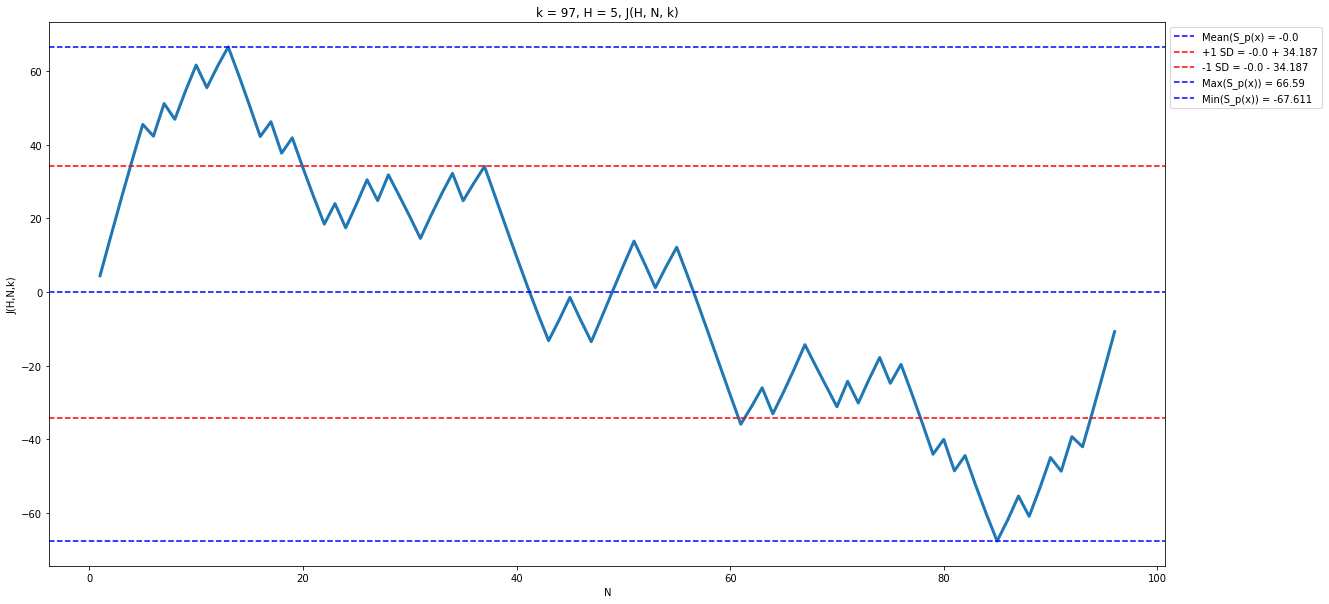

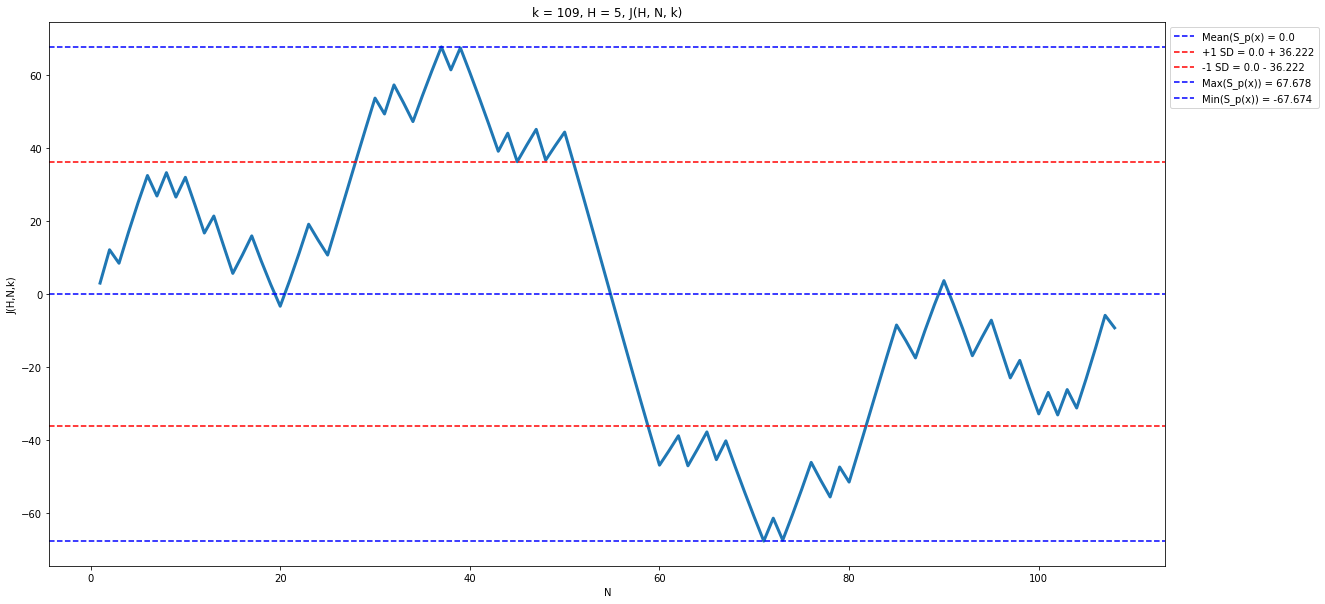

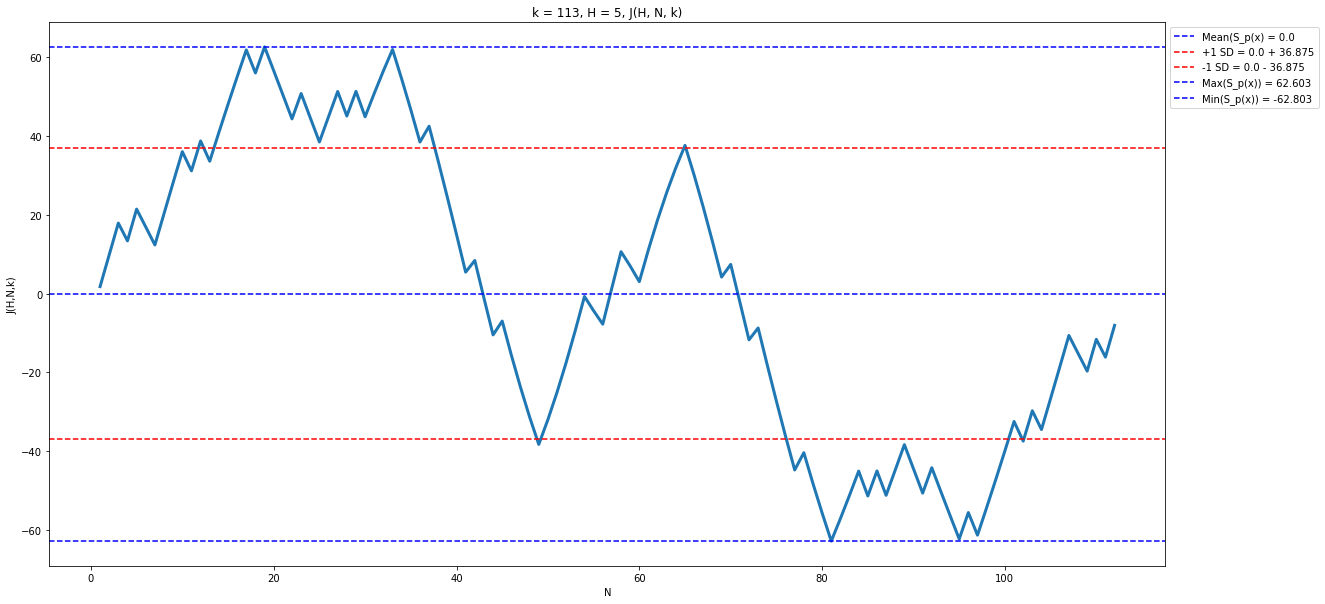

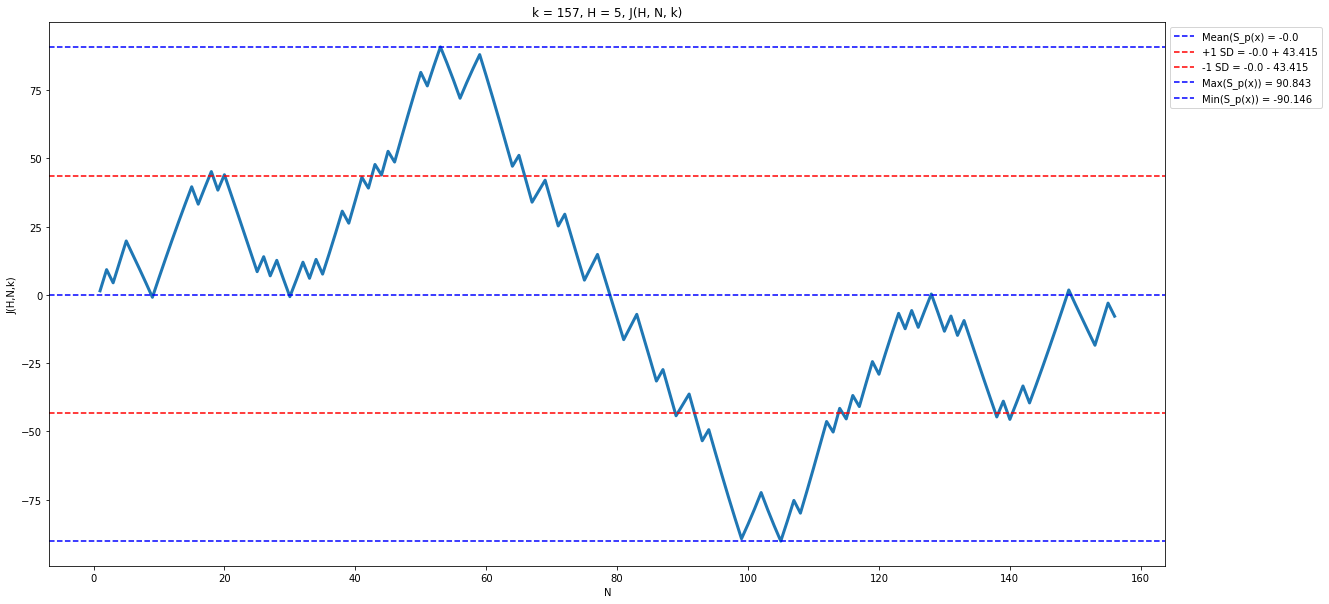

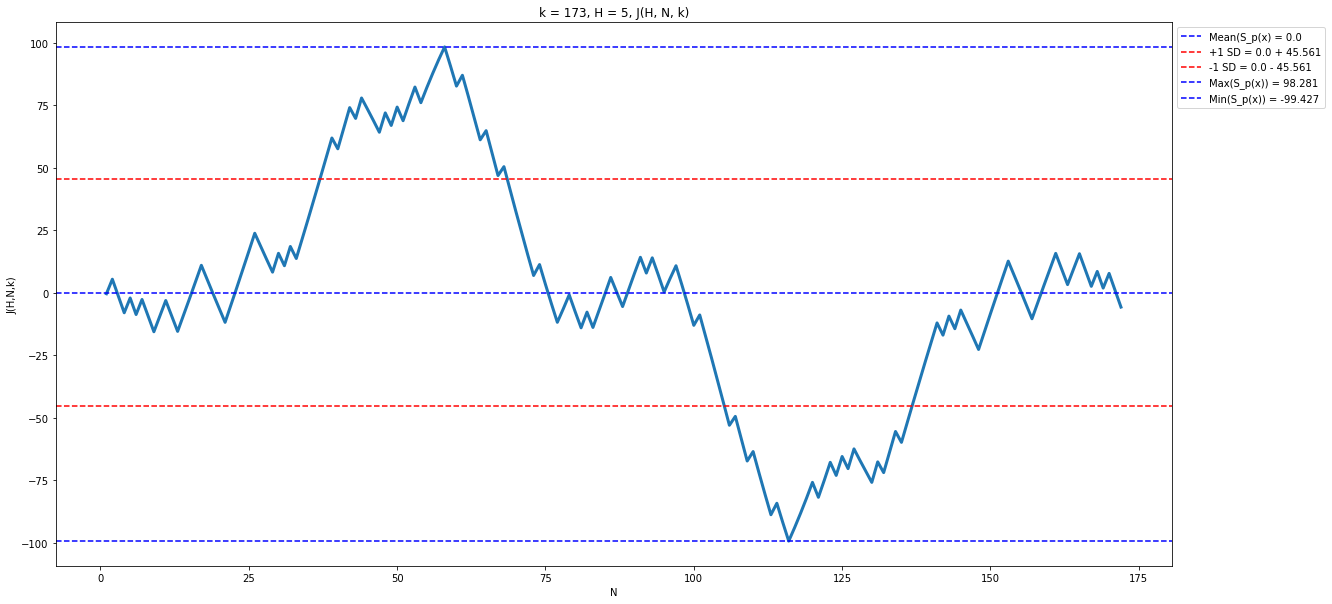

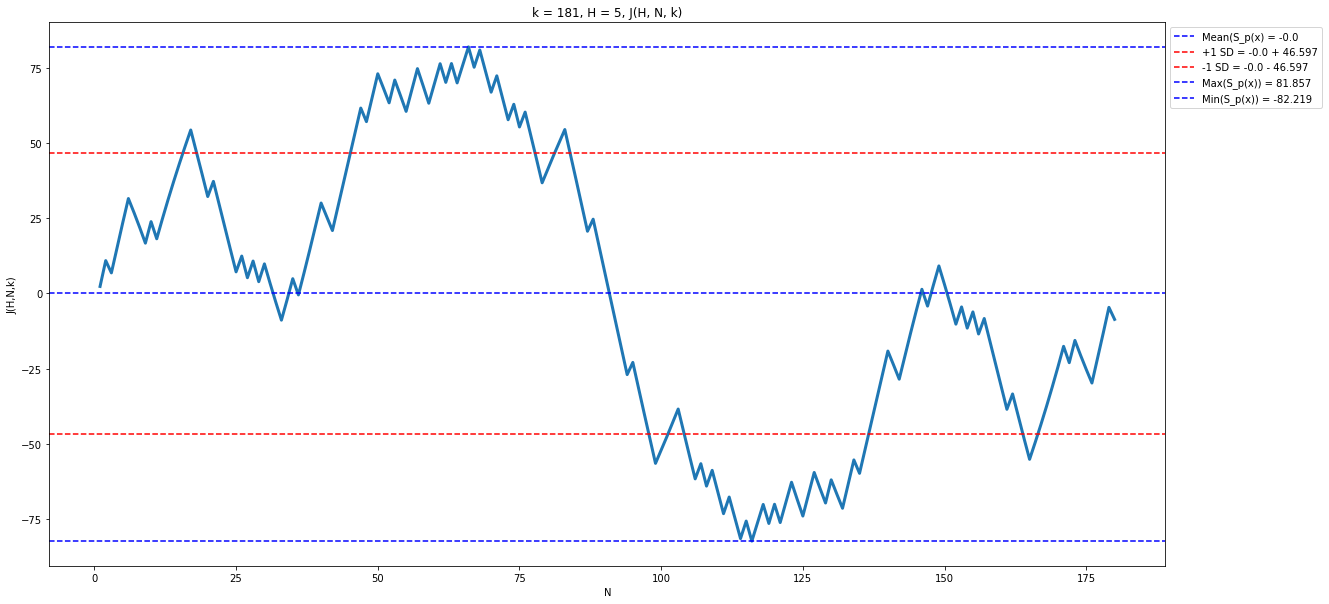

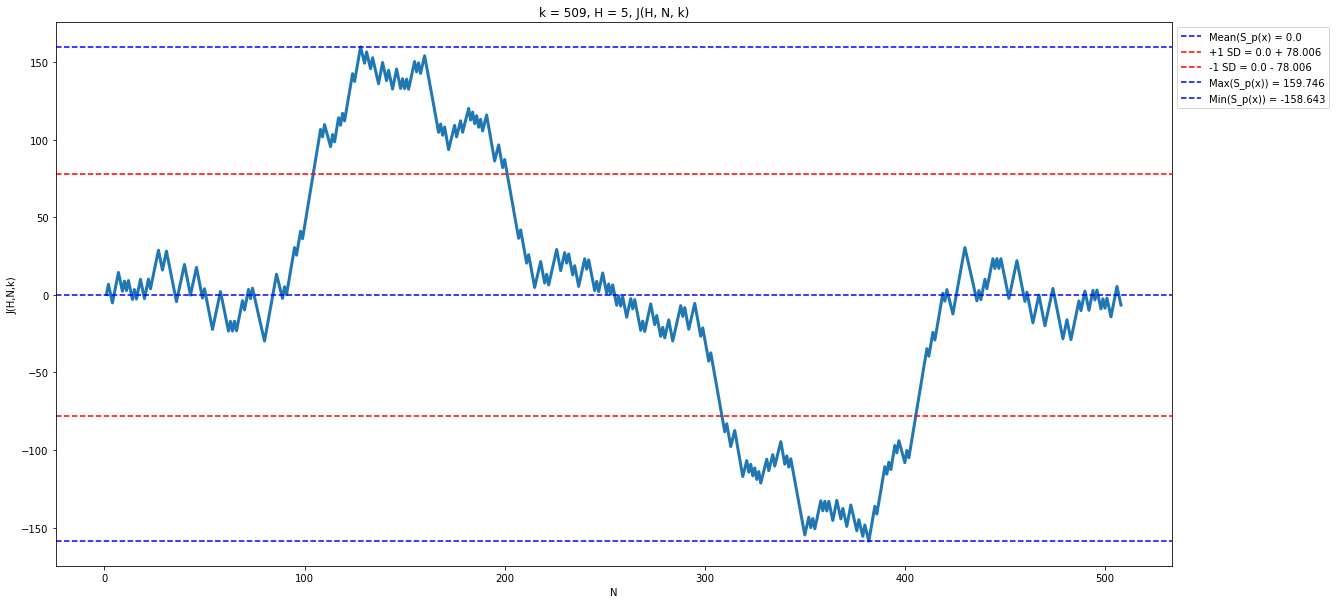

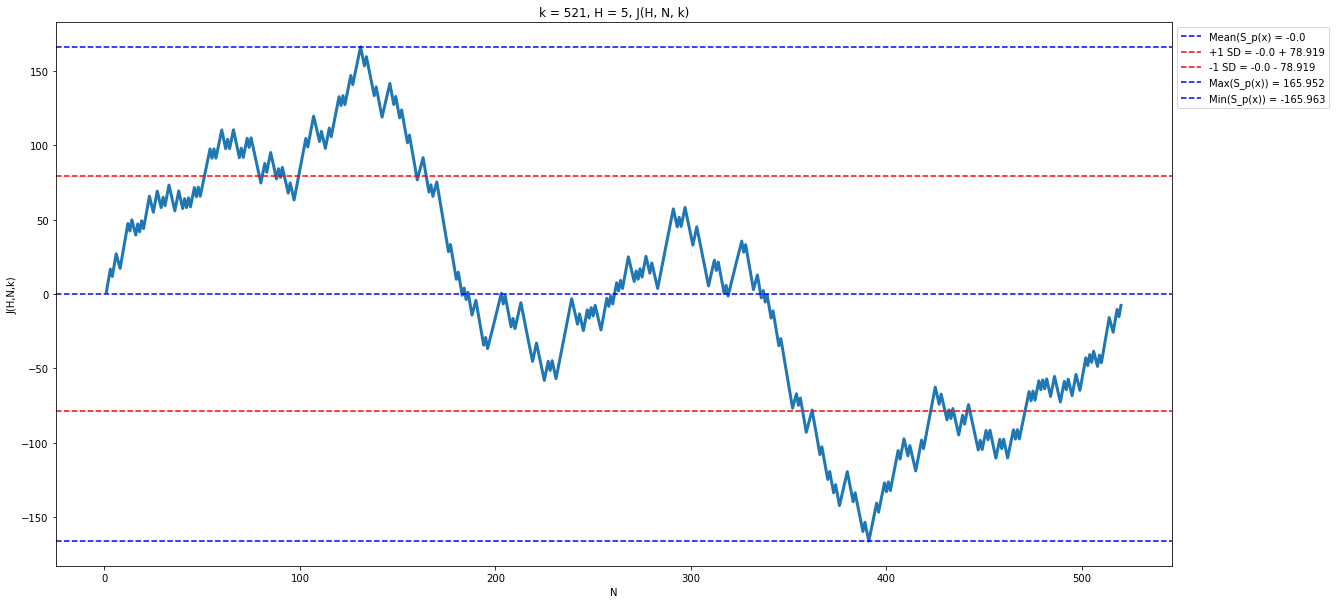

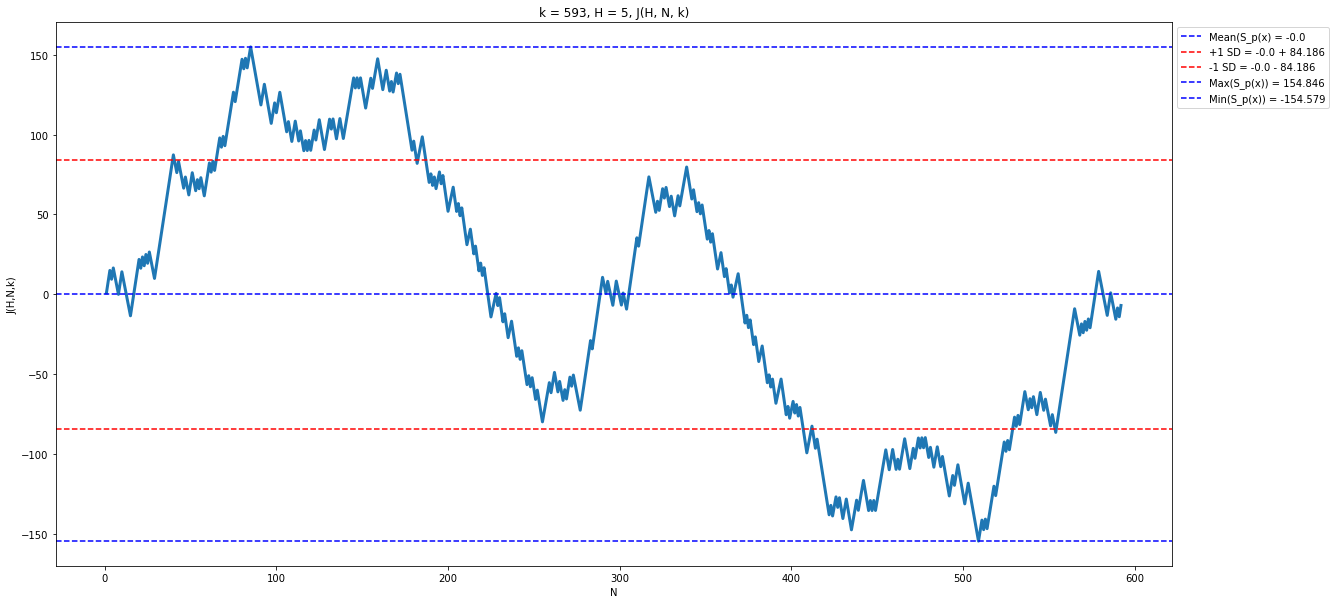

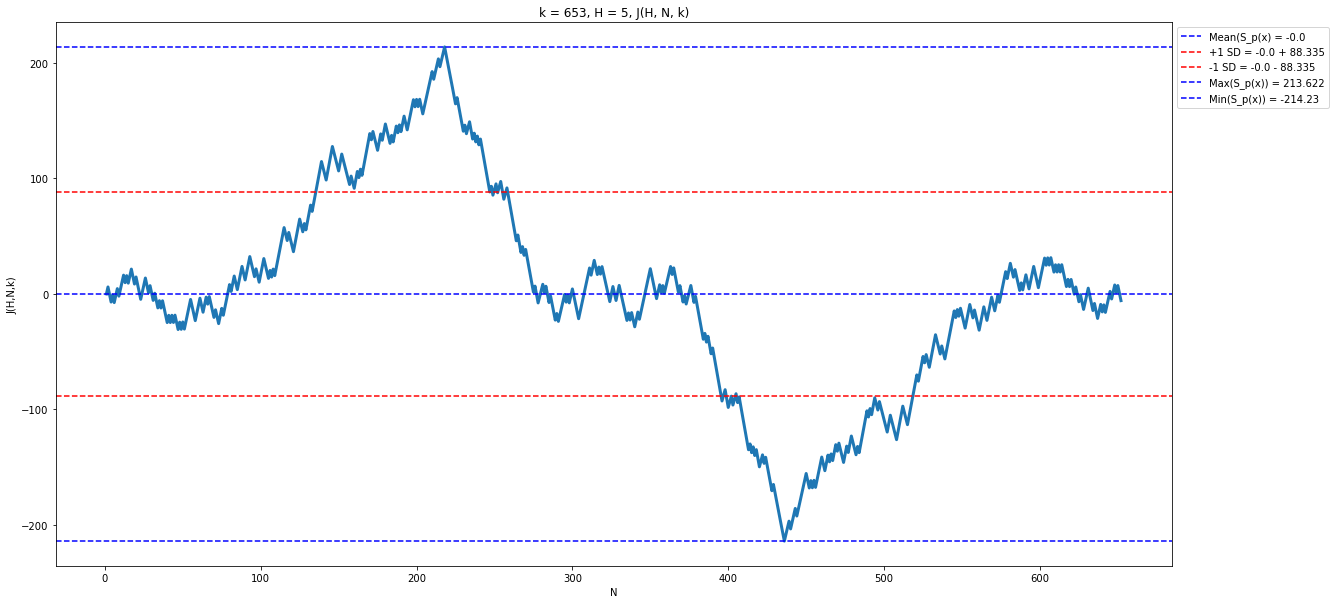

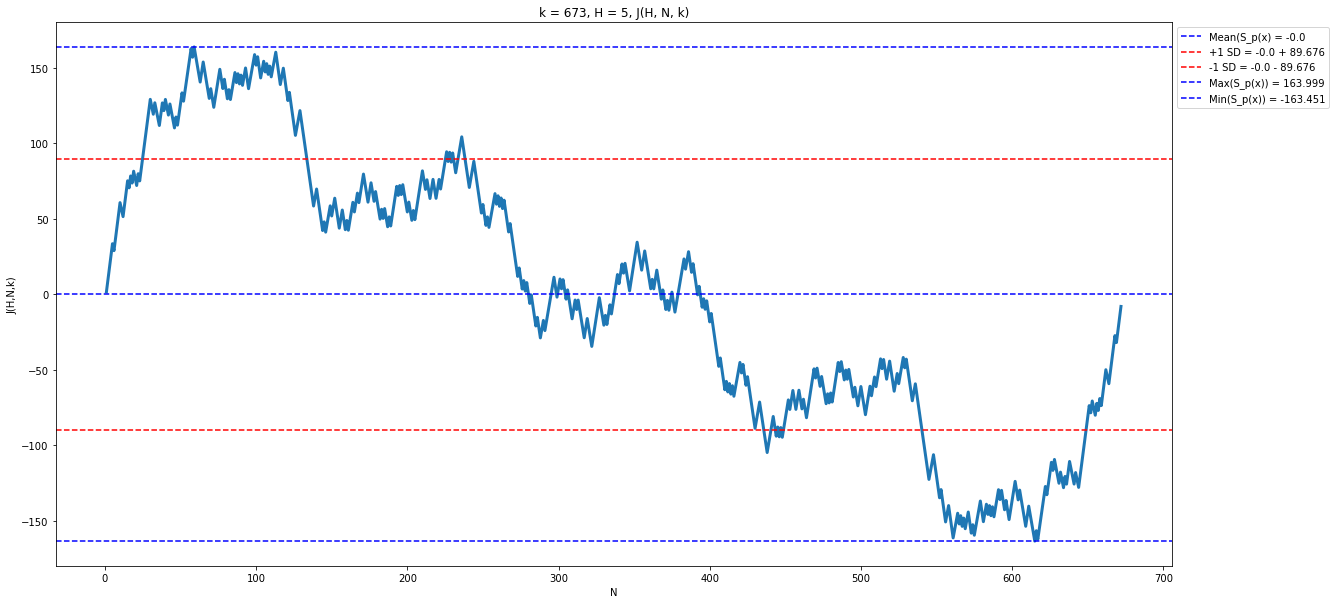

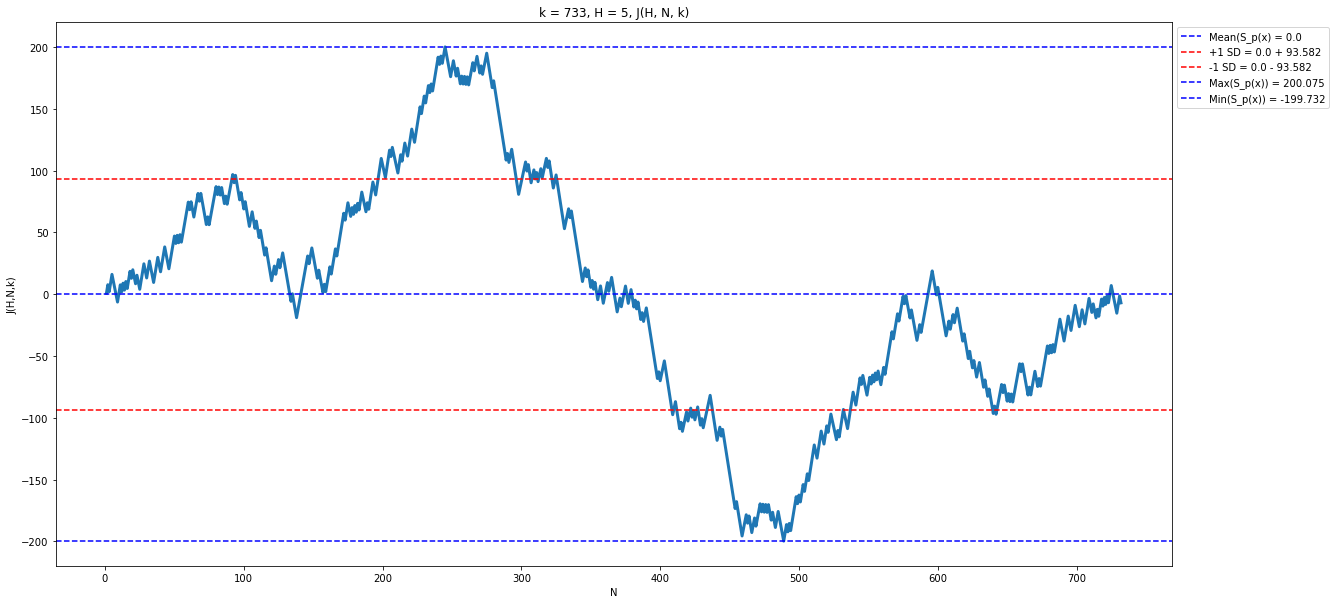

In [5]:
def plot(k, H):
    fig, ax = plt.subplots(figsize=(20,10))
    x = np.arange(1, k)
    y = data[(k,H)]
    ax.plot(x, y,linewidth=3)
    mean, sd = np.mean(y), np.std(y)
    largest, smallest = max(y), min(y)
    ax.set_xlabel('N')
    ax.set_ylabel('J(H,N,k)')
    ax.set_title(f"k = {k}, H = {H}, J(H, N, k)")
    mean, sd = np.mean(y), np.std(y)
    largest, smallest = max(y), min(y)
    
    ax.axhline(y=mean, color='b', linestyle='--', label=f"Mean(S_p(x) = {round(mean, 3)}")
    ax.axhline(y=mean + sd, color='r', linestyle='--', label=f"+1 SD = {round(mean,3)} + {round(sd, 3)}")
    ax.axhline(y=mean - sd, color='r', linestyle='--', label=f"-1 SD = {round(mean,3)} - {round(sd, 3)}")
    ax.axhline(y=largest, color='b', linestyle='--', label=f"Max(S_p(x)) = {round(largest, 3)}")
    ax.axhline(y=smallest, color='b', linestyle='--', label=f"Min(S_p(x)) = {round(smallest,3)}")
    
    ax.legend(bbox_to_anchor=(1, 1))
    
for k, H in sorted(data):
    plot(k, H)